### Pseudotemporal Ordering
Single-cell sequencing assays provide high resolution measurements of biological tissues. However, since cells are destroyed when sequenced in classical single-cell RNA sequencing (scRNA-seq), it is impossible to track their development and, for example, gene expression profile over time. Consequently, the underlying dynamic process needs to be estimated from the measured snapshot data, instead. Even though samples are, traditionally, taken from a single experimental time point, a multitude of cell types can be observed. This diversity stems from the asynchronous nature of biological processes. As such, a range of the developmental process can be observed. Reconstructing the developmental landscape is the goal of trajectory inference (TI). This task is achieved by ordering the observed cellular states according to the developmental process. States are aligned along the developmental direction by mapping discrete annotations to a continuous domain - the so-called pseudotime. Pseudotimes rank cells relative to each other according to their respective stage in the developmental process. Less mature cells are assigned small, mature cells large values. Studying a bone marrow sample for example, hematopoietic stem cells are assigned a low, and erythroid cells a high pseudotime. 

In [1]:
import os
import scanpy as sc

#### Load Data

We study a dataset of adult human bone marrow.

In [2]:
adata = sc.read(
    filename="./bone_marrow.h5ad",
    backup_url="https://figshare.com/ndownloader/files/35826944",
)
adata

AnnData object with n_obs × n_vars = 5780 × 27876
    obs: 'clusters', 'palantir_pseudotime', 'palantir_diff_potential'
    var: 'palantir'
    uns: 'clusters_colors', 'palantir_branch_probs_cell_types'
    obsm: 'MAGIC_imputed_data', 'X_tsne', 'palantir_branch_probs'
    layers: 'spliced', 'unspliced'

#### Data Preprocessing

In [ ]:
sc.pp.filter_genes(adata, min_counts=20)
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata)

sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=10)

#### Dimensionality Reduction

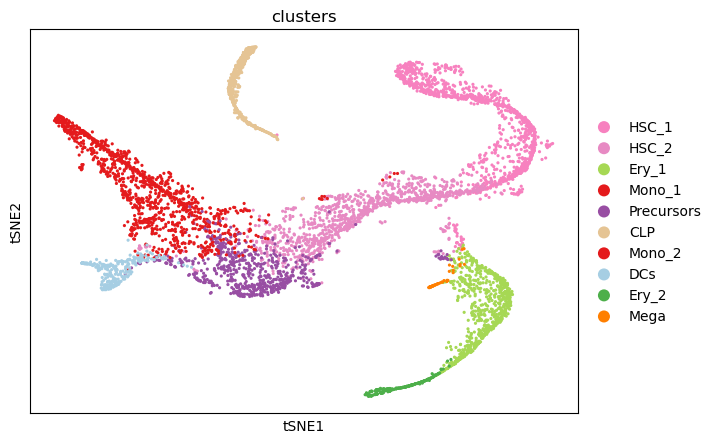

In [4]:
sc.pl.scatter(adata, basis="tsne", color="clusters")

The two-dimensional t-SNE representation colored by cell type annotations shows that the cell types cluster together well. Additionally, the developmental hierarchy is visible.

#### Pseudotime Construction

As a first step, the ultra high-dimensional single-cell data is projected onto a lower dimensional representation. Pseudotime methods may rely on principal components or diffusion components. Following, pseudotimes are constructed based on one of the following principles.

- The cluster approach: Observations are first clustered and, connections between these clusters identified. The clusters can be ordered and, thereby, a pseudotime constructed. Henceforth, we will refer to this apporoach as the cluster approach. Classical cluster algorithms include k-means, Leiden, or hierarchical clustering. Clusters may also be connected based on similarity, or by constructing a minimum spanning tree (MST).

- The graph approach: First find connections between the lower dimensional representation of the observations. This procedure defines a graph based on which clusters, and thus an ordering, are defined. Intuitively, this approach preserves the global topology of the data while analyzing it at a lower resolution. Consequently, the computational efficiency is increased.

- Manifold-learning based approaches: This class of methods proceed similar to the cluster approach. However, connections between clusters are defined by using principal curves or graphs to estimate the underlying trajectories. Principal curves find a one-dimensional curve that connects cellular observations in the higher dimensional space.

- Probabilistic frameworks assign transition probabilities to ordered cell-cell pairs. Each transition probabilitiy quantifies how likely the reference cell is the ancestor of the other cell. These probabilities define random processes that are used to define a pseudotime. diffusion pseudotime (DPT) is defined as the difference between consecutive states of a random walk. This method requires a root cell to be specified. The pseudotime itself is computed with respect to this cell.

To calculate diffusion pseudotime (DPT), first, the corresponding diffusion maps need to be calculated.

In [5]:
sc.tl.diffmap(adata)

To identify a putative initial cell, we study the individual diffusion components. We identify the stem cell with the most extreme diffusion component in one dimension.

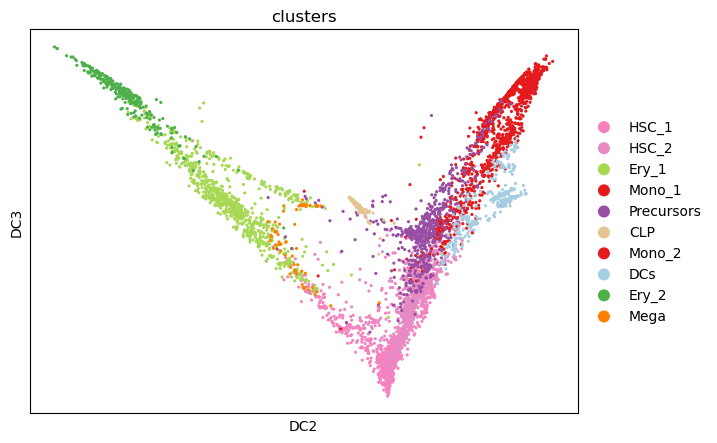

In [6]:
root_ixs = adata.obsm["X_diffmap"][:, 3].argmin()
sc.pl.scatter(
    adata,
    basis="diffmap",
    color=["clusters"],
    components=[2, 3],
)

adata.uns["iroot"] = root_ixs

In [7]:
# calculate the DPT, saved as the attribute 'dpt_pseudotime' by default
sc.tl.dpt(adata)

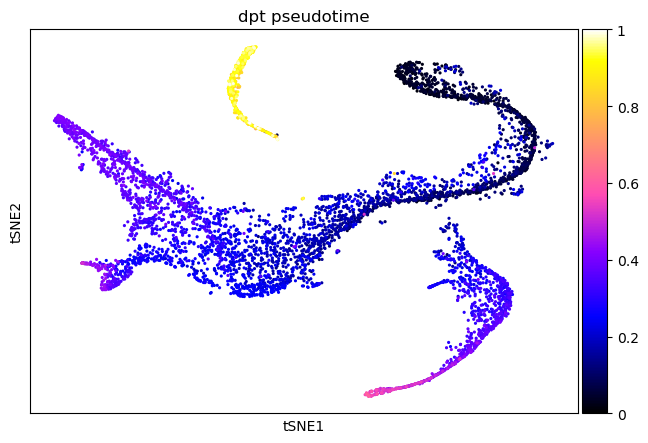

In [ ]:
sc.pl.scatter(
    adata,
    basis="tsne",
    color="dpt_pseudotime",
    color_map="gnuplot2",
)

#### The following violin plot shows for each cell type, the probability distribution and essentially the evolution in pseudotime scale

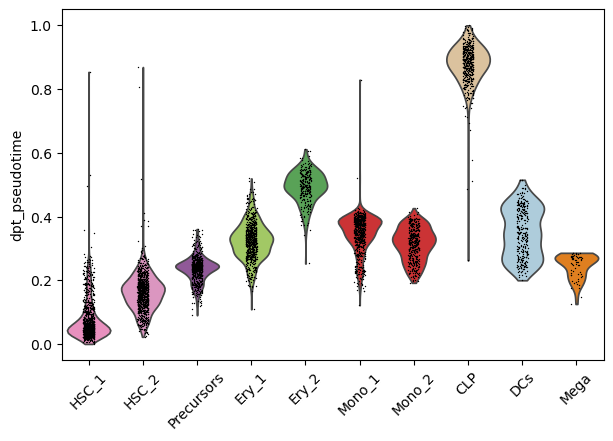

In [9]:
sc.pl.violin(
    adata,
    keys=["dpt_pseudotime"],
    groupby="clusters",
    rotation=45,
    order=[
        "HSC_1", # Hematopoietic Stem Cell, 1 and 2 mark different states for cell types and same applies for the following ones
        "HSC_2",
        "Precursors", # progenitor cells, descendants of stem cells that are on the way of becoming more blood cells
        "Ery_1", # erythrocytes, or red blood cell
        "Ery_2",
        "Mono_1", # subpopulations of monocytes
        "Mono_2",
        "CLP", # progenitor cells that initiate the lymphoid lineage of blood cells
        "DCs", # Dendritic cells
        "Mega", # Megakaryocytes, production of platelets and blood clotting    
    ],
)